In [1]:

import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, time, warnings
from datetime import datetime #DB
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras.backend               import set_session
from tensorflow.keras                       import backend #, models
from tensorflow.keras.models                import load_model
from tensorflow.keras.utils                 import plot_model #DB

import gc #DB
from config import fcn_config as cfg
from config import fcn8_cnn as cnn

warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
config.gpu_options.visible_device_list = "0"
set_session(tf.compat.v1.Session(config=config))




fcn_config.py runs from  /workspace/Vitis-AI-Tutorials-2.5/Tutorials/Keras_FCN8_UNET_segmentation/files/code


In [3]:
print(y_test1_i.shape,y_pred1_i.shape)

(4, 224, 224) (4, 224, 224)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


validation data (X) (Y) shapes: (9, 224, 224, 3) (9, 224, 224, 5)
testing    data (X) (Y) shapes (4, 224, 224, 3) (4, 224, 224, 5)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

now computing IoU over testing data set:
class ( 0)   background: #TP=    506, #FP=    305, #FN=   1875, IoU=0.188
class ( 1)          end: #TP=   1007, #FP=    595, #FN=    672, IoU=0.443
class ( 2)        floor: #TP= 121836, #FP=   2054, #FN=    452, IoU=0.980
class ( 3)        trash: #TP=    932, #FP=    422, #FN=    395, IoU=0.533
class ( 4)         wall: #TP=  71908, #FP=   1139, #FN=   1121, IoU=0.970
_________________
Mean IoU: 0.623

now com

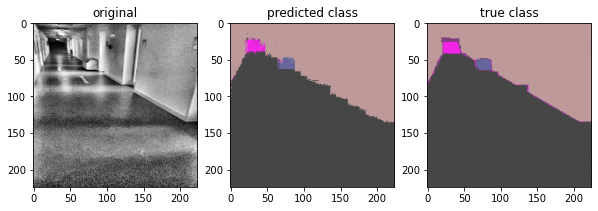

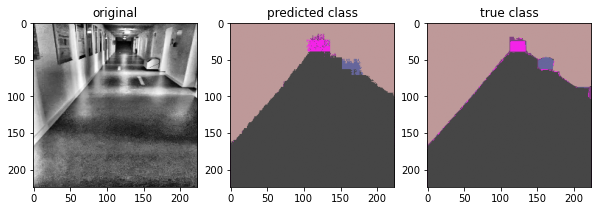

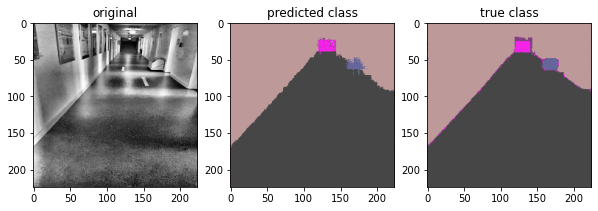

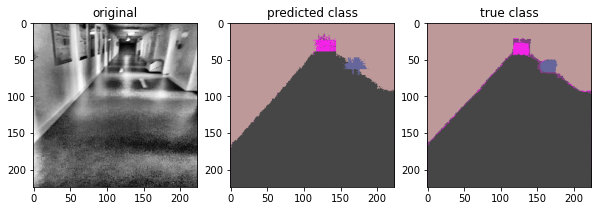

In [2]:


HEIGHT = cfg.HEIGHT
WIDTH  = cfg.WIDTH
N_CLASSES = cfg.NUM_CLASSES
EPOCHS = cfg.EPOCHS
UPSCALE=False

dir_data = cfg.DATASET_DIR
dir_train_img = cfg.dir_train_img
dir_train_seg = cfg.dir_train_seg
dir_test_img  = cfg.dir_test_img
dir_test_seg  = cfg.dir_test_seg
dir_calib_img = cfg.dir_calib_img
dir_calib_seg = cfg.dir_calib_seg
dir_valid_img = cfg.dir_valid_img
dir_valid_seg = cfg.dir_valid_seg

######################################################################
# model
######################################################################

#model = UNET((HEIGHT, WIDTH, 3))

model = cnn.FCN8(nClasses     = N_CLASSES,
             input_height = HEIGHT,
             input_width  = WIDTH,
                 upscale = UPSCALE)


######################################################################
# prepare testing and validation data
######################################################################

# load validation images
valid_images = os.listdir(dir_valid_img)
valid_images.sort()
valid_segmentations  = os.listdir(dir_valid_seg)
valid_segmentations.sort()
X_valid = []
Y_valid = []
for im , seg in zip(valid_images,valid_segmentations) :
    X_valid.append( cnn.NormalizeImageArr(os.path.join(dir_valid_img, im)) )
    Y_valid.append( cnn.LoadSegmentationArr( os.path.join(dir_valid_seg, seg), N_CLASSES , WIDTH, HEIGHT)  )
X_valid, Y_valid = np.array(X_valid) , np.array(Y_valid)
print("\n")
print("validation data (X) (Y) shapes:", X_valid.shape,Y_valid.shape)


# load testing images
test_images = os.listdir(dir_test_img)
test_images.sort()
test_segmentations  = os.listdir(dir_test_seg)
test_segmentations.sort()
X_test = []
Y_test = []
for im , seg in zip(test_images,test_segmentations) :
    X_test.append( cnn.NormalizeImageArr(os.path.join(dir_test_img,im)) )
    Y_test.append( cnn.LoadSegmentationArr(os.path.join(dir_test_seg, seg), N_CLASSES , WIDTH, HEIGHT)  )
X_test, Y_test = np.array(X_test) , np.array(Y_test)
print("testing    data (X) (Y) shapes", X_test.shape,Y_test.shape)
print("\n")

#########################################################################################################
# Calculate intersection over union for each segmentation class

if UPSCALE==False :
    model_filename= "../keras_model/fcn8/ep"    + str(EPOCHS) + "_trained_fcn8_"    + str(WIDTH) + "x" + str(HEIGHT) + ".hdf5"
else :
    model_filename= "../keras_model/fcn8ups/ep" + str(EPOCHS) + "_trained_fcn8ups_" + str(WIDTH) + "x" + str(HEIGHT) + ".hdf5"

model = load_model(model_filename) #DB

print("\nnow computing IoU over testing data set:")
y_pred1   = model.predict(X_test)
y_pred1_i = np.argmax(y_pred1, axis=3)
y_test1_i = np.argmax(Y_test, axis=3)
#print(y_test1_i.shape,y_pred1_i.shape)

np.save("ref_y_pred.npy",   y_pred1)
np.save("ref_y_pred_i.npy", y_pred1_i)
np.save("ref_y_test.npy",   Y_test)
np.save("ref_y_test_i.npy", y_test1_i)

cnn.IoU(y_test1_i, y_pred1_i)

print("\nnow computing IoU over validation data set:")
y_pred2 = model.predict(X_valid)
y_pred2_i = np.argmax(y_pred2, axis=3)
y_test2_i = np.argmax(Y_valid, axis=3)
#print(y_test2_i.shape,y_pred2_i.shape)
cnn.IoU(y_test2_i,y_pred2_i)


#########################################################################################################

# Visualize the model performance
cnn.visualize_model_performance(X_test, y_pred1_i, y_test1_i, N_CLASSES, UPSCALE)

In [4]:
print(y_pred1)

[[[[1.41458202e-06 1.79401377e-06 2.20039409e-09 4.29940002e-07
    9.99996305e-01]
   [1.95308161e-08 6.42323599e-08 2.08631584e-10 2.82571850e-08
    9.99999881e-01]
   [6.53874865e-09 1.87261939e-08 7.60056948e-11 8.01956013e-09
    1.00000000e+00]
   ...
   [2.45932431e-04 3.40733910e-04 3.84707419e-05 1.00734060e-05
    9.99364793e-01]
   [1.49140961e-03 1.91120198e-03 3.53317417e-04 7.59715913e-05
    9.96168077e-01]
   [4.85467957e-04 1.26840652e-03 2.49031611e-04 1.29106847e-04
    9.97867942e-01]]

  [[2.55693317e-06 3.31252318e-06 1.61828617e-09 4.22291095e-07
    9.99993682e-01]
   [1.37861429e-08 8.24687518e-08 9.43829875e-11 4.21726831e-08
    9.99999881e-01]
   [8.12079648e-09 2.01313544e-08 2.93390451e-11 5.96521499e-09
    1.00000000e+00]
   ...
   [2.34359206e-04 7.81798037e-04 3.71897004e-05 1.76755784e-05
    9.98928964e-01]
   [8.61261215e-04 2.70477403e-03 1.71916457e-04 1.81658950e-04
    9.96080458e-01]
   [1.04427002e-02 9.94580053e-03 3.33098415e-03 3.62403778e

In [5]:
print(y_pred1.shape)

(4, 224, 224, 5)
